In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device('cuda')

from evaluate import test_network
from prune import prune_network

In [3]:
!python -Wi main.py --train-flag --epoch 10 --data-set CIFAR10 --vgg vgg16_bn --save-path ./trained_models/

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 10
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None
Make dir:  ./trained_models/
170499072it [00:05, 29137034.00it/s]                                            
Extracting ../cifar-10-python.tar.gz to ../
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:12:27 2022: Epoch [0], Iteration [0/391/], Data(s): 0.038, Loss(s): 0.002, Forward(s): 0.181, Backward(s): 0.221, Top1: 13.281, Top5: 58.5938, Loss: 2.348
Sun Dec 11 05:12:32 2022: Epoch [0], I

In [4]:
print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")

Original Model Size = 57.3 MB


In [5]:
# load_path = 'trained_model/vgg16_bn_cifar10/'

load_path = 'trained_models/'
args = torch.load(load_path+'arguments.pth')

for key, value in vars(args).items():
    print("%s: %s"%(key, value))

#################################
args.load_path = load_path + 'check_point.pth'
args.save_path = load_path+'%s/'%time.ctime().replace(' ', '_')
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 10
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None


In [6]:
network, test_set, (top1, top5) = test_network(args)

Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:15:56 2022: Test information, Data(s): 1.466, Forward(s): 0.271, Top1: 71.480, Top5: 97.010, 


In [7]:
print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")
params = sum([np.prod(p.size()) for p in network.parameters()])
print("Original Number of Parameters: %.1fM"%(params/1e6))

Original Model Size = 57.3 MB
Original Number of Parameters: 15.0M


In [8]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

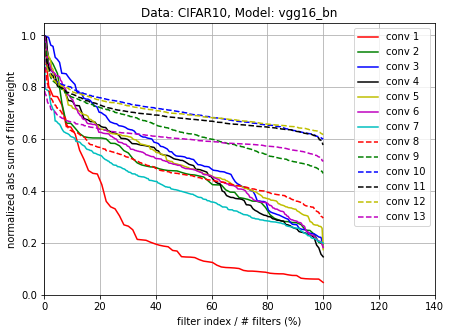

In [9]:
plt.figure(figsize=(7,5))
conv_count = 0
fw_list = []

for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # filter weight dimension info: out_ch, in_ch, k1, k2
        fw = layer.weight.data.cpu().numpy()
        fw_list.append(fw)
        
        # sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # normalize with maximum value
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("Data: %s, Model: %s"%(args.data_set, args.vgg))        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()

In [10]:
for i, fw in enumerate(fw_list):
    # print(f'Conv{i+1} total sum = {np.sum(np.abs(fw.reshape(fw.shape[0], -1))):.3f}')
    sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
    normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
    print(f'Conv{i+1} Normalized sum = {np.sum(normalized_abs_sum):.3f}')
    print()

Conv1 Normalized sum = 16.130

Conv2 Normalized sum = 30.485

Conv3 Normalized sum = 69.185

Conv4 Normalized sum = 63.729

Conv5 Normalized sum = 133.057

Conv6 Normalized sum = 128.612

Conv7 Normalized sum = 106.210

Conv8 Normalized sum = 249.227

Conv9 Normalized sum = 325.718

Conv10 Normalized sum = 362.963

Conv11 Normalized sum = 354.473

Conv12 Normalized sum = 362.241

Conv13 Normalized sum = 311.206



In [11]:
print('--- Before Pruning ---')
print(network)

--- Before Pruning ---
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [12]:
prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

In [13]:
from collections import defaultdict

In [14]:
top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

for conv, channel in zip(prune_layers, prune_channels):
    print(f' ============== Working with layer {conv} ============== ')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    print('--------------- Testing Network ---------------')
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels = [steps[i]]
        print('--------------- Pruning Network ---------------')
        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
    print(' ============================ ')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))

 ============== Working with layer conv1 ============== 
--------------- Testing Network ---------------
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:16:01 2022: Test information, Data(s): 1.525, Forward(s): 0.235, Top1: 71.480, Top5: 97.010, 

Sun Dec 11 05:16:01 2022: conv1 Layer, 8 Channels pruned
--------------- Pruning Network ---------------
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:16:03 2022: Test information, Data(s): 1.469, Forward(s): 0.226, Top1: 71.610, Top5: 97.010, 

Sun Dec 11 05:16:04 2022: conv1 Layer, 16 Channels pruned
--------------- Pruning Network ---------------
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:16:06 2022: Test information, Data(s): 1.479, Forward(s): 0.2

In [15]:
model_size

defaultdict(list,
            {'conv1': [57.256035804748535],
             'conv2': [57.256035804748535],
             'conv3': [57.256035804748535],
             'conv4': [57.256035804748535],
             'conv5': [57.256035804748535],
             'conv6': [57.256035804748535],
             'conv7': [57.256035804748535],
             'conv8': [57.256035804748535],
             'conv9': [57.256035804748535],
             'conv10': [57.256035804748535],
             'conv11': [57.256035804748535],
             'conv12': [57.256035804748535],
             'conv13': [57.256035804748535]})

In [16]:
model_params

defaultdict(list,
            {'conv1': [14.957404],
             'conv2': [14.893279],
             'conv3': [14.792881],
             'conv4': [14.594161],
             'conv5': [14.196376],
             'conv6': [13.931416],
             'conv7': [13.401496],
             'conv8': [11.811046],
             'conv9': [10.751206],
             'conv10': [10.751206],
             'conv11': [10.751206],
             'conv12': [10.751206],
             'conv13': [12.635366]})

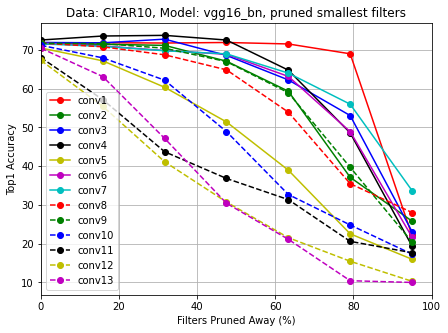

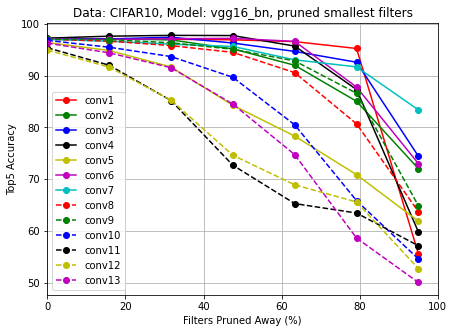

In [17]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [18]:
args.retrain_flag = True
args.retrain_epoch = 3
args.independent_prune_flag = False
args.retrain_lr = 0.001

In [22]:
top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

for conv, channel in zip(prune_layers, prune_channels):
#     !rm trained_models/check_point_pruned.pth
    print(f' ============== Working with layer {conv} ============== ')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

    print(' ============================ ')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))
    print(' ============================ ')


 ============== Working with layer conv1 ============== 
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:31:28 2022: Test information, Data(s): 1.497, Forward(s): 0.228, Top1: 71.480, Top5: 97.010, 

Sun Dec 11 05:31:29 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*-
	Train network
-*--*--*--*--*--*--*--*--*--*-
Sun Dec 11 05:31:29 2022: Epoch [0], Iteration [0/391/], Data(s): 0.035, Loss(s): 0.002, Forward(s): 0.004, Backward(s): 0.006, Top1: 79.688, Top5: 98.4375, Loss: 0.593
Sun Dec 11 05:31:34 2022: Epoch [0], Iteration [100/391/], Data(s): 0.031, Loss(s): 0.002, Forward(s): 0.003, Backward(s): 0.006, Top1: 80.531, Top5: 98.4994, Loss: 0.585
Sun Dec 11 05:31:39 2022: Epoch [0], Iteration [200/391/], Data(s): 0.031, Loss(s): 0.002, Forward(s): 0.003, Backward(s): 0.006, Top1: 81.604, Top5: 98.7135, Loss: 0

In [23]:
import matplotlib.pyplot as plt

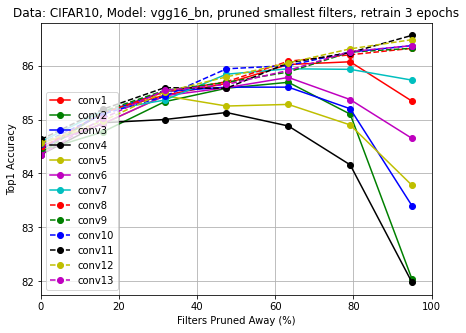

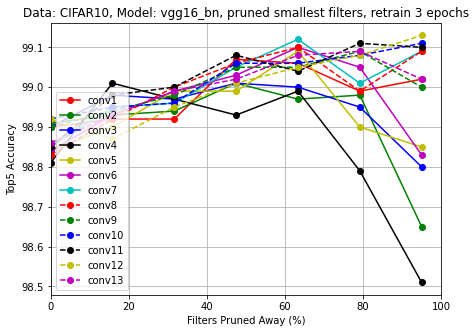

In [24]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [25]:
model_size

defaultdict(list,
            {'conv1': [0.0],
             'conv2': [0.0],
             'conv3': [0.0],
             'conv4': [0.0],
             'conv5': [0.0],
             'conv6': [0.0],
             'conv7': [0.0],
             'conv8': [0.0],
             'conv9': [0.0],
             'conv10': [0.0],
             'conv11': [0.0],
             'conv12': [0.0],
             'conv13': [0.0]})

In [26]:
model_params

defaultdict(list,
            {'conv1': [14.957404],
             'conv2': [14.893279],
             'conv3': [14.792881],
             'conv4': [14.594161],
             'conv5': [14.196376],
             'conv6': [13.931416],
             'conv7': [13.401496],
             'conv8': [11.811046],
             'conv9': [10.751206],
             'conv10': [10.751206],
             'conv11': [10.751206],
             'conv12': [10.751206],
             'conv13': [12.635366]})

In [28]:
import torch
import torchvision.models as models

class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16_bn', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [33]:
!pip install thop

In [35]:
import Torch_Pruning.torch_pruning as tp

In [52]:
def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.6, 0.1, 0.15, 0.1, 0.1, 0.15, 0.15, 0.2, 0.8, 0.8, 0.8, 0.4, 0.4]
    conv_id = 0
    for m in model.features:
        if isinstance( m, torch.nn.Conv2d ):
            print(conv_id, m)
            prune_conv( m, block_prune_probs[conv_id] )
            conv_id += 1
    return model

In [53]:
model = prune_model(network)

0 Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 Conv2d(18, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(40, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 Conv2d(58, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 Conv2d(62, 134, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(121, 134, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 Conv2d(114, 103, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(88, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(164, 415, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 Conv2d(83, 415, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 Conv2d(83, 415, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 Conv2d(83, 415, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 Conv2d(249, 43, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [56]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(18, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(40, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(58, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(62, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(62, 121, kern

In [55]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 1.0M


In [58]:
def get_dataloader():
    train_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=True, transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), download=True),batch_size=args.batch_size, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ]),download=True),batch_size=args.batch_size, num_workers=2)
    return train_loader, test_loader

In [74]:
def eval(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

In [59]:
def train_model(model, train_loader, test_loader):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.step_size, 0.1)
    model.to(device)

    best_acc = -1
    for epoch in range(args.total_epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
            if i%10==0 and args.verbose:
                print("Epoch %d/%d, iter %d/%d, loss=%.4f"%(epoch, args.total_epochs, i, len(train_loader), loss.item()))
        model.eval()
        acc = eval(model, test_loader)
        print("Epoch %d/%d, Acc=%.4f"%(epoch, args.total_epochs, acc))
        if best_acc<acc:
            torch.save( model, 'resnet18-round%d.pth'%(args.round) )
            best_acc=acc
        scheduler.step()
    print("Best Acc=%.4f"%(best_acc))

In [64]:
train_loader, test_loader = get_dataloader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [63]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 

In [76]:
args.step_size = 70
args.total_epochs = 30
args.verbose = 0
args.round = 1

In [78]:
train_model(model, train_loader, test_loader)

Epoch 0/30, Acc=0.8272
Epoch 1/30, Acc=0.8118
Epoch 2/30, Acc=0.7938
Epoch 3/30, Acc=0.8323
Epoch 4/30, Acc=0.8225
Epoch 5/30, Acc=0.8265
Epoch 6/30, Acc=0.8233
Epoch 7/30, Acc=0.8229
Epoch 8/30, Acc=0.8308
Epoch 9/30, Acc=0.8053
Epoch 10/30, Acc=0.8535
Epoch 11/30, Acc=0.8281
Epoch 12/30, Acc=0.8401
Epoch 13/30, Acc=0.8291
Epoch 14/30, Acc=0.8175
Epoch 15/30, Acc=0.8335
Epoch 16/30, Acc=0.8304
Epoch 17/30, Acc=0.8349
Epoch 18/30, Acc=0.8010
Epoch 19/30, Acc=0.8052
Epoch 20/30, Acc=0.8498
Epoch 21/30, Acc=0.8270
Epoch 22/30, Acc=0.8498
Epoch 23/30, Acc=0.8302
Epoch 24/30, Acc=0.8337
Epoch 25/30, Acc=0.8480
Epoch 26/30, Acc=0.8428
Epoch 27/30, Acc=0.8508
Epoch 28/30, Acc=0.8500
Epoch 29/30, Acc=0.8318
Best Acc=0.8535


In [79]:
model = prune_model(model)

0 Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 Conv2d(8, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(36, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 Conv2d(50, 62, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 Conv2d(56, 121, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(109, 114, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 Conv2d(97, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(75, 164, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(132, 83, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 Conv2d(17, 83, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 Conv2d(17, 83, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 Conv2d(17, 249, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 Conv2d(150, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [80]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 0.4M


In [81]:
args.round = 2

In [83]:
train_model(model, train_loader, test_loader)

Epoch 0/30, Acc=0.8219
Epoch 1/30, Acc=0.8289
Epoch 2/30, Acc=0.8156
Epoch 3/30, Acc=0.8008
Epoch 4/30, Acc=0.8369
Epoch 5/30, Acc=0.8467
Epoch 6/30, Acc=0.8086
Epoch 7/30, Acc=0.8522
Epoch 8/30, Acc=0.8595
Epoch 9/30, Acc=0.8421
Epoch 10/30, Acc=0.8205
Epoch 11/30, Acc=0.8395
Epoch 12/30, Acc=0.8417
Epoch 13/30, Acc=0.8406
Epoch 14/30, Acc=0.8365
Epoch 15/30, Acc=0.8152
Epoch 16/30, Acc=0.8492
Epoch 17/30, Acc=0.8534
Epoch 18/30, Acc=0.8541
Epoch 19/30, Acc=0.8553
Epoch 20/30, Acc=0.8441
Epoch 21/30, Acc=0.8514
Epoch 22/30, Acc=0.8333
Epoch 23/30, Acc=0.8379
Epoch 24/30, Acc=0.8435
Epoch 25/30, Acc=0.8257
Epoch 26/30, Acc=0.7998
Epoch 27/30, Acc=0.8470
Epoch 28/30, Acc=0.8357
Epoch 29/30, Acc=0.8203
Best Acc=0.8595


In [84]:
model = prune_model(model)

0 Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 Conv2d(4, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(33, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 Conv2d(43, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 Conv2d(51, 109, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(99, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 Conv2d(83, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(64, 132, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(106, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 Conv2d(4, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 Conv2d(4, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 Conv2d(4, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 Conv2d(90, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [85]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 0.3M


In [86]:
train_model(model, train_loader, test_loader)

Epoch 0/30, Acc=0.7763
Epoch 1/30, Acc=0.7913
Epoch 2/30, Acc=0.7989
Epoch 3/30, Acc=0.7915
Epoch 4/30, Acc=0.8244
Epoch 5/30, Acc=0.8129
Epoch 6/30, Acc=0.8382
Epoch 7/30, Acc=0.8214
Epoch 8/30, Acc=0.8198
Epoch 9/30, Acc=0.8364
Epoch 10/30, Acc=0.8313
Epoch 11/30, Acc=0.8255
Epoch 12/30, Acc=0.8351
Epoch 13/30, Acc=0.8186
Epoch 14/30, Acc=0.8114
Epoch 15/30, Acc=0.8287
Epoch 16/30, Acc=0.8432
Epoch 17/30, Acc=0.8316
Epoch 18/30, Acc=0.8309
Epoch 19/30, Acc=0.8217
Epoch 20/30, Acc=0.8159
Epoch 21/30, Acc=0.8392
Epoch 22/30, Acc=0.8363
Epoch 23/30, Acc=0.8130
Epoch 24/30, Acc=0.8323
Epoch 25/30, Acc=0.8312
Epoch 26/30, Acc=0.8611
Epoch 27/30, Acc=0.8468
Epoch 28/30, Acc=0.8327
Epoch 29/30, Acc=0.8499
Best Acc=0.8611
